<a href="https://colab.research.google.com/github/philarnold4242/test_Python/blob/master/Bayesian_DL_ConvNet_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4 - Convolutional Neural Nets<br>
https://www.tensorflow.org/tutorials/deep_cnn

In [0]:
N = 50 # Number of samples for forward pass
Ntrain_steps = 500
bayesian_keep_prob = 0.8

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Uncertainties<br>
Helper functions

In [0]:
# Pseudocount - needs thinking.
pc = 1e-10

def softmax(x):
    """ Multinomial logisitc fuction. """
    mmax = np.amax(x, axis=1).reshape(x.shape[0], 1)
    ex = np.exp(x - mmax)
    ex_sum = ex.sum(axis=1).reshape(ex.shape[0],1)
    return ex / ex_sum
    

def var_ratio(x):
    """ How spread is the distribution around the mode?""" 
    ratios = np.zeros(shape=(x.shape[1]))
    
    # Loop over test examples
    for n in range(x.shape[1]):
        
        # Get predicted class
        samples_n = np.argmax(x[:, n], axis=1)
        
        # Get most abundant class
        count = np.argmax(np.bincount(samples_n))
        
        # Return frequency of class
        ratios[n] = np.sum(samples_n==count) / x.shape[0]

    return ratios


def pred_ent(x):
    """ Average amount of information contained in posterior predictive distribution. """
    
    N = x.shape[1] # Number of test cases
    T = x.shape[0] # Number of samples per test case
    C = 10 # number of classes
    
    entropies = np.zeros(shape=(x.shape[1]))
    
    # Loop over test examples
    for n in range(N):
        
        # Approx posterior predictive distribution
        ppd = np.mean(x[:,n,:] + pc, axis=0)
        
        # Calculate predictive entropy
        entropies[n] = - np.sum(np.multiply(ppd, np.log(ppd)))
    
    return entropies


def mut_inf(x):
    """ MI between prediction y_pred and posterior distribution for the model parameters. """
    
    N = x.shape[1] # Number of test cases
    T = x.shape[0] # Number of samples per test case
    C = 10 # number of classes
        
    mis = np.zeros(shape=(x.shape[1]))
    
    # Loop over test examples
    for n in range(N):
        
        # Approx posterior predictive distribution
        ppd = np.mean(x[:,n,:] + pc, axis=0)
        
        # Calculate predictive entropy
        pe = - np.sum(np.multiply(ppd, np.log(ppd)))
        
        # Calculate conditional entropy        
        p = x[:,n,:] + pc
        logp = np.log(p)
        ce = np.sum(np.multiply(p,logp))
        
        mis[n] = 1/T * pe + ce
    
    return mis

## **Let's get started**

### Set up modules

In [89]:
import os
import sys

import numpy as np
np.set_printoptions(precision=5)

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import urllib
import tarfile

!pip install git+git://github.com/rasbt/mlxtend.git
from mlxtend.data import loadlocal_mnist

import tensorflow as tf
print(tf.__version__)

  Cloning git://github.com/rasbt/mlxtend.git to /tmp/pip-req-build-ie_26k7a
  Running setup.py bdist_wheel for mlxtend ... - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-hdrg3s13/wheels/85/e4/4c/ee71547ac9ea223b07fe8f55b0e5f71536a6a34ae3480205f3
Successfully built mlxtend
1.12.0


In [90]:
## Check GPU
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


### ConvNet - The hard way

In [91]:
## Load MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
## Helper functions
def weight_variable(shape):
    """ Specifies the weight for either fully-connected or conv layers."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """ Bias elements. """
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    """ This specifies a full convolution with an output the same size
        as the input x. 
        [batch, height, width, channels] """
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """ ksize: A 1-D int Tensor of 4 elements. The size of the window for each 
               dimension of the input tensor.
        strides: A 1-D int Tensor of 4 elements. The stride of the sliding window for 
                 each dimension of the input tensor. """
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [0]:
## Architecture parameters
pic_res = 28
n_channel = 1

# Placeholders to feed stuff to network
x = tf.placeholder(tf.float32, shape=[None, pic_res*pic_res])
y_true = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)




In [0]:
def create_convnet(do_bayes = False):
  ## The net
  # Remember, the input image is a 1D tensor of length 784.
  mnist.train.images[1].shape

  # To apply the layer, we first reshape x to a 4d tensor, with the second and 
  # third dimensions corresponding to image width and height, and the final dimension 
  # corresponding to the number of color channels.
  x_image = tf.reshape(x, [-1, pic_res, pic_res, n_channel])

  # First conv layer
  # The convolution will compute 32 features for each 3x3 patch. Its weight tensor will have a 
  # shape of [3, 3, 1, 32]. The first two dimensions are the patch size, the next is the number 
  # of input channels, and the last is the number of output channels. 
  W_conv1 = weight_variable([3, 3, n_channel, 32])
  b_conv1 = bias_variable([32])
  conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  if do_bayes:
    conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob)
  h_pool1 = max_pool_2x2(conv1)

  # Second conv layer
  W_conv2 = weight_variable([3, 3, 32, 64])
  b_conv2 = bias_variable([64])
  conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
  if do_bayes:
    conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)
  h_pool2 = max_pool_2x2(conv2)

  # Dense layer 
  pic_res4_sq = int(pic_res/4)*int(pic_res/4)
  W_fc1 = weight_variable([pic_res4_sq * 64, 1024])
  b_fc1 = bias_variable([1024])

  h_pool2_flat = tf.reshape(h_pool2, [-1, pic_res4_sq*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
  # Dropout
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob=keep_prob)

  # Output
  W_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])

  h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob=keep_prob)
  y_conv = h_fc2_drop
  
  return(y_conv)

## Tranditional ConvNet

In [0]:
# Objective function
y_conv = create_convnet(do_bayes = False)
y_pred = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_conv)
cross_entropy = tf.reduce_mean(y_pred)

# Optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Evaluation
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [96]:
## Train - MNIST
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(int(Ntrain_steps)+1):
    batch = mnist.train.next_batch(64)

    # Training
    _, loss = sess.run([train_step, cross_entropy], 
                       feed_dict={x: batch[0], y_true: batch[1], 
                                  keep_prob: float(bayesian_keep_prob)})
    
    # Status report
    if i % 1000 == 0:
        train_acc = sess.run(accuracy, feed_dict={x: batch[0], 
                                                  y_true: batch[1], 
                                                  keep_prob: float(1.0)})
        
        test_acc = sess.run(accuracy, feed_dict={x: mnist.test.images,
                                                  y_true: mnist.test.labels, 
                                                  keep_prob: 1.0})
        info = [str(tx) for tx in [i, loss, train_acc, test_acc] ]
        print('\t'.join(info))

0	5.0555906	0.171875	0.1126


In [0]:
# Get predictions
y_prob = tf.nn.softmax(y_conv)
pred_trad = sess.run(y_prob, feed_dict={x: mnist.test.images,
                                          y_true: mnist.test.labels, 
                                          keep_prob: 1.0})


labels_trad = np.argmax(pred_trad, axis=1)
probs_trad = np.max(pred_trad, axis=1)

## Bayesian ConvNet

In [0]:
# Objective function
By_conv = create_convnet(do_bayes = True)
By_pred = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=By_conv)
Bcross_entropy = tf.reduce_mean(By_pred)

# Optimizer
Btrain_step = tf.train.AdamOptimizer(1e-4).minimize(Bcross_entropy)

# Evaluation
Bcorrect_prediction = tf.equal(tf.argmax(By_conv, 1), tf.argmax(y_true, 1))
Baccuracy = tf.reduce_mean(tf.cast(Bcorrect_prediction, tf.float32))

In [99]:
## Train - MNIST
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(int(Ntrain_steps)+1):
    batch = mnist.train.next_batch(64)

    # Training
    _, loss = sess.run([Btrain_step, Bcross_entropy], 
                       feed_dict={x: batch[0], y_true: batch[1], 
                                  keep_prob: float(bayesian_keep_prob)})
    
    # Status report
    if i % 1000 == 0:
        train_acc = sess.run(Baccuracy, feed_dict={x: batch[0], 
                                                  y_true: batch[1], 
                                                  keep_prob: float(1.0)})
        
        test_acc = sess.run(Baccuracy, feed_dict={x: mnist.test.images,
                                                  y_true: mnist.test.labels, 
                                                  keep_prob: 1.0})
        info = [str(tx) for tx in [i, loss, train_acc, test_acc] ]
        print('\t'.join(info))

0	6.4715066	0.109375	0.0735


**Uncertainties from stochastic forward passes**

In [0]:
## Stochastic forward passes
samples = np.zeros( shape=(N, mnist.test.images.shape[0], 10))

for n in range(N):
    logits = sess.run(By_conv, feed_dict={x: mnist.test.images, 
                                          y_true: mnist.test.labels,
                                         keep_prob: bayesian_keep_prob})
    samples[n] = softmax(logits)

In [101]:
# Variation ratio
vr = var_ratio(samples)

# Predictive entropy
pe = pred_ent(samples)

# Mutual information
mi = mut_inf(samples)

mi

array([-15.12189, -23.74139, -21.73925, ..., -26.85388, -32.04399,
       -19.22744])

In [0]:
def pred_ent_trad(x):
    """ Average amount of information contained in posterior predictive distribution. """

    N = x.shape[0]
    C = x.shape[1]
    
    entropies = np.zeros(shape=(N))    
    
    for n in range(N):

      # Predictive entropy for traditional approach (just softmax)
      ppd = x[n, :]

      # Calculate predictive entropy
      pe = - np.sum(np.multiply(ppd, np.log(ppd)))
        
      entropies[n] = pe
      
    return(entropies)
  
pe_trad = pred_ent_trad(pred_trad)

In [103]:
import math

y = pred_trad[9679]
print(y)

z = 0.0
for i in range(10):
  
  z = z + y[i] * math.log(y[i])
  
print(z)
print(pe_trad[9679])

[0.0694  0.04272 0.10561 0.36325 0.0059  0.13199 0.26648 0.0106  0.00066
 0.00339]
-1.6474440670139534
1.6474441289901733


In [0]:
# Bayesian predictions
samples_avg = np.sum(samples, axis=0) / N
labels_bayes = np.argmax(samples_avg, axis=1)
probs_bayes = np.max(samples_avg, axis=1)

## Comparison: Bayes vs Trad

In [105]:
ref = np.argmax(mnist.test.labels, axis=1)
data = { 'true': ref.tolist(),
         'labels_trad': labels_trad.tolist(),
         'probs_trad': probs_trad.tolist(),
         'labels_bayes': labels_bayes.tolist(),
         'probs_bayes': probs_bayes.tolist(),
         'vr': vr.tolist(),
         'pe': pe.tolist(),
         'mi': mi.tolist(),
         'pe_trad': pe_trad.tolist()}

df = pd.DataFrame(data)

df = df.assign(correct_trad = df.true == df.labels_trad)
df = df.assign(correct_bayes = df.true == df.labels_bayes)

df_both_wrong = df[(df.correct_trad == False) & (df.correct_bayes == False)]
df_both_right = df[(df.correct_trad == True) & (df.correct_bayes == True)]

df.head()

,labels_bayes,labels_trad,mi,pe,pe_trad,probs_bayes,probs_trad,true,vr,correct_trad,correct_bayes
0,7,7,-15.121886,0.661247,0.004074,0.864051,0.999595,7,0.84,True,True
1,2,2,-23.741389,0.850190,0.152811,0.813040,0.975134,2,0.92,True,True
2,1,1,-21.739251,0.770152,0.078970,0.834280,0.989269,1,1.00,True,True
3,0,0,-16.470451,0.743732,0.054788,0.846117,0.992900,0,0.98,True,True
4,4,4,-24.233514,0.909586,0.064878,0.801393,0.990818,4,0.78,True,True


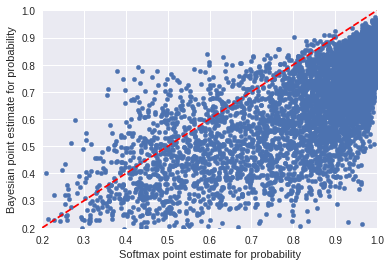

In [106]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = "red")

# Best guess
# Traditional approach is much more confidennt than Bayesian approach
ax = df.plot.scatter(x = 'probs_trad', y = 'probs_bayes')
ax.set_xlim(0.2, 1)
ax.set_ylim(0.2, 1)
ax.set_xlabel("Softmax point estimate for probability")
ax.set_ylabel("Bayesian point estimate for probability")
abline(1, 0)

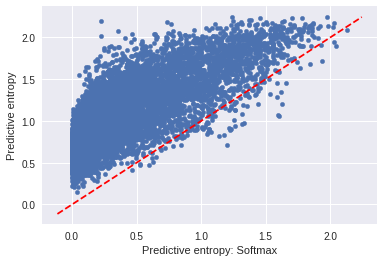

In [107]:
ax = df.plot.scatter(x = 'pe_trad', y = 'pe')
#ax.set_xlim(0.0, 1)
#ax.set_ylim(0., 1)
ax.set_xlabel("Predictive entropy: Softmax")
ax.set_ylabel("Predictive entropy")
abline(1, 0)

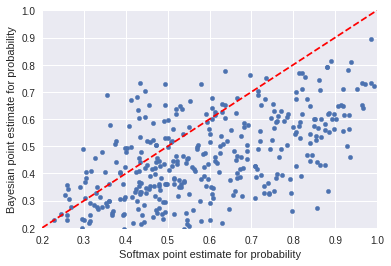

In [108]:
# Things both got wrong
ax = df_both_wrong.plot.scatter(x = 'probs_trad', y = 'probs_bayes')
ax.set_xlim(0.2, 1)
ax.set_ylim(0.2, 1)
ax.set_xlabel("Softmax point estimate for probability")
ax.set_ylabel("Bayesian point estimate for probability")
abline(1, 0)

In [0]:
# Uncertainty measure for correct / incorrectly predicted digits
# https://stackoverflow.com/questions/21887625/python-empirical-distribution-function-ecdf-implementation
df_bayes_correct = df[df.correct_bayes == True]
df_bayes_wrong = df[df.correct_bayes == False]

df_trad_correct = df[df.correct_trad == True]
df_trad_wrong = df[df.correct_trad == False]

In [0]:
# Bayes
uncer_bayes_correct = df_bayes_correct.pe.value_counts()
uncer_bayes_correct = uncer_bayes_correct.sort_index(ascending=False).cumsum()*1./len(uncer_bayes_correct)

uncer_bayes_wrong = df_bayes_wrong.pe.value_counts()
uncer_bayes_wrong = uncer_bayes_wrong.sort_index(ascending=False).cumsum()*1./len(uncer_bayes_wrong)

# Trad
uncer_trad_correct = df_trad_correct.pe_trad.value_counts()
uncer_trad_correct = uncer_trad_correct.sort_index(ascending=False).cumsum()*1./len(uncer_trad_correct)

uncer_trad_wrong = df_trad_wrong.pe_trad.value_counts()
uncer_trad_wrong = uncer_trad_wrong.sort_index(ascending=False).cumsum()*1./len(uncer_trad_wrong)

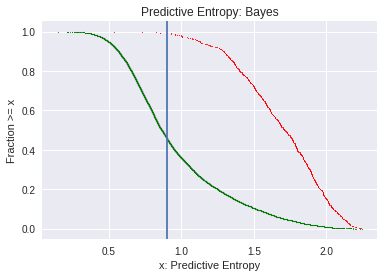

In [117]:
si = 0.5
plt.scatter(uncer_bayes_correct.index, uncer_bayes_correct, color="green", s=si)
plt.scatter(uncer_bayes_wrong.index, uncer_bayes_wrong, color="red", s=si)
plt.title("Predictive Entropy: Bayes")
plt.xlabel("x: Predictive Entropy")
plt.ylabel("Fraction >= x")
plt.axvline(0.9)

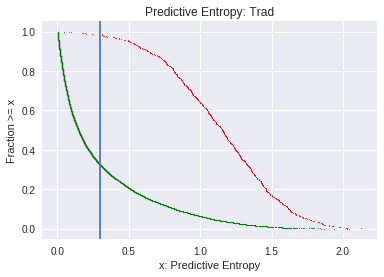

In [119]:
plt.scatter(uncer_trad_correct.index, uncer_trad_correct, color="green", s=si)
plt.scatter(uncer_trad_wrong.index, uncer_trad_wrong, color="red", s=si)
plt.title("Predictive Entropy: Trad")
plt.xlabel("x: Predictive Entropy")
plt.ylabel("Fraction >= x")
plt.axvline(0.3)

Text(0,0.5,'Fraction >= x')

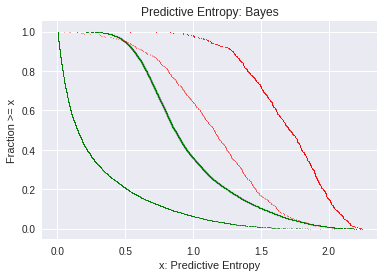

In [113]:
plt.scatter(uncer_bayes_correct.index, uncer_bayes_correct, color="green", s=0.5)
plt.scatter(uncer_bayes_wrong.index, uncer_bayes_wrong, color="red", s=0.5)

plt.scatter(uncer_trad_correct.index, uncer_trad_correct, color="green", s =0.1)
plt.scatter(uncer_trad_wrong.index, uncer_trad_wrong, color="red", s =0.1)

plt.title("Predictive Entropy: Bayes")
plt.xlabel("x: Predictive Entropy")
plt.ylabel("Fraction >= x")

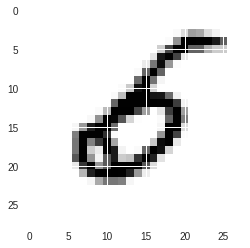

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


,labels_bayes,labels_trad,mi,pe,pe_trad,probs_bayes,probs_trad,true,vr,correct_trad,correct_bayes
92,4,4,-73.033318,1.926230,1.397889,0.341316,0.425087,9,0.58,False,False
175,1,1,-70.152948,1.787567,1.185955,0.420237,0.446761,7,0.72,False,False
217,5,5,-53.217109,1.475786,0.794432,0.546301,0.804761,6,0.72,False,False
247,6,6,-45.171718,1.344695,1.616585,0.576980,0.360900,4,0.70,False,False
259,0,0,-37.576521,1.161860,0.812854,0.579518,0.691676,6,0.64,False,False
290,4,4,-64.987371,1.800911,1.322675,0.425282,0.398741,8,0.58,False,False
318,3,3,-37.583827,1.132055,1.082112,0.728111,0.492980,2,0.88,False,False
320,1,1,-64.535150,1.647813,1.148889,0.501289,0.624388,9,0.74,False,False
321,7,7,-71.532093,1.881077,0.884264,0.395806,0.772928,2,0.66,False,False
340,3,3,-64.777056,1.706674,1.103567,0.461864,0.676036,5,0.72,False,False


In [114]:
k = 9729
# 9729	6	6	-36.121928	0.768686	0.829598	0.995529	5	0.82	False	False
plt.imshow(mnist.test.images[k].reshape(28,28))
plt.show()
print(mnist.test.labels[k])
df_both_wrong

## EMnist
We know that in this case, the data set is out of distribution. Usually, we don't have this information.

In [78]:
# Download data set from here: https://www.nist.gov/itl/iad/image-group/emnist-dataset
# Upload to gDrive
# Copy from gDrive
!cp '/content/drive/My Drive/Colab Notebooks/emnist.zip' .

!rm -fr gzip

# Unzip
!unzip emnist.zip

Archive:  emnist.zip
  inflating: gzip/emnist-balanced-mapping.txt  
  inflating: gzip/emnist-balanced-test-images-idx3-ubyte.gz  
 extracting: gzip/emnist-balanced-test-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-balanced-train-images-idx3-ubyte.gz  
  inflating: gzip/emnist-balanced-train-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-byclass-mapping.txt  
  inflating: gzip/emnist-byclass-test-images-idx3-ubyte.gz  
  inflating: gzip/emnist-byclass-test-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-byclass-train-images-idx3-ubyte.gz  
  inflating: gzip/emnist-byclass-train-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-bymerge-mapping.txt  
  inflating: gzip/emnist-bymerge-test-images-idx3-ubyte.gz  
  inflating: gzip/emnist-bymerge-test-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-bymerge-train-images-idx3-ubyte.gz  
  inflating: gzip/emnist-bymerge-train-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-digits-mapping.txt  
  inflating: gzip/emnist-digits-test-images-idx3-

In [0]:
import gzip

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]


def extract_images(filename):
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError(
                'Invalid magic number %d in MNIST image file: %s' %
                (magic, filename))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data


def extract_labels(filename):
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError(
              'Invalid magic number %d in MNIST label file: %s' %
              (magic, filename))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
        return labels


def read_emnist(emnist_dir):

    TRAIN_IMAGES = emnist_dir+'/emnist-balanced-train-images-idx3-ubyte.gz'
    TRAIN_LABELS = emnist_dir+'/emnist-balanced-train-labels-idx1-ubyte.gz'
    TEST_IMAGES = emnist_dir+'/emnist-balanced-test-images-idx3-ubyte.gz'
    TEST_LABELS = emnist_dir+'/emnist-balanced-test-labels-idx1-ubyte.gz'
    MAPPING = emnist_dir+'/emnist-balanced-mapping.txt'

    train_images = extract_images(TRAIN_IMAGES)
    train_labels = extract_labels(TRAIN_LABELS)
    test_images = extract_images(TEST_IMAGES)
    test_labels = extract_labels(TEST_LABELS)

    with open(MAPPING, "r") as f:
        mapping = f.readlines()
        mapping = {str(x.split()[0]): str(x.split()[1]) for x in mapping}

    # Convert to float32
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')

    # Normalize
    train_images /= 255
    test_images /= 255

    # Output format: (28, 28, 1)
    return ((train_images, train_labels), (test_images, test_labels), mapping)

In [80]:
emnist = read_emnist('gzip')

X = np.float32(emnist[1][0].reshape(18800, 784))
y = np.float32(emnist[1][1])
X.shape

(18800, 784)

In [0]:
# Predict digits
eN = 18800

y_prob = tf.nn.softmax(y_conv)
pred_trad = sess.run(y_prob, feed_dict={x: X,
                                          y_true: mnist.test.labels, 
                                          keep_prob: float(1.0)})


labels_trad = np.argmax(pred_trad, axis=1)
probs_trad = np.max(pred_trad, axis=1)

Eprobs_trad = probs_trad

In [0]:
## Stochastic forward passes
Esamples = np.zeros( shape=(N, X.shape[0], 10))

for n in range(N):
    logits = sess.run(By_conv, feed_dict={x: X, 
                                          y_true: mnist.test.labels[0:eN],
                                          keep_prob: 0.9})
    Esamples[n] = softmax(logits)

Esamples_avg = np.sum(Esamples, axis=0) / N
Elabels_bayes = np.argmax(Esamples_avg, axis=1)
Eprobs_bayes = np.max(Esamples_avg, axis=1)

(18800,)
(18800,)


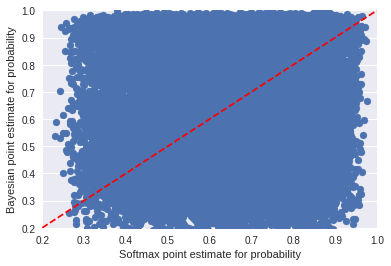

In [83]:
print(Eprobs_trad.shape)
print(Eprobs_bayes.shape)
ax = plt.scatter(Eprobs_trad, Eprobs_bayes)
plt.xlim(0.2, 1)
plt.ylim(0.2, 1)
plt.xlabel("Softmax point estimate for probability")
plt.ylabel("Bayesian point estimate for probability")
abline(1, 0)

34.0
0.5745657 ; 
0.8972969765961171 ;  7


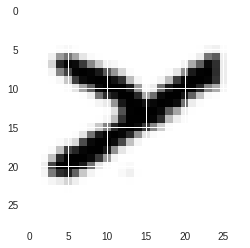

In [84]:
# Pick some examples
As = np.argwhere(y==15)

i = 11215

print(y[i])
print(Eprobs_trad[i], "; ")
print(Eprobs_bayes[i], "; ", Elabels_bayes[i])

plt.imshow(X[i].reshape((28,28)))

In [85]:
As

array([[  138],
       [  189],
       [  263],
       [  267],
       [  283],
       [  297],
       [  335],
       [  371],
       [  410],
       [  447],
       [  527],
       [  551],
       [  567],
       [  677],
       [  681],
       [  758],
       [  770],
       [  826],
       [  852],
       [  955],
       [ 1015],
       [ 1050],
       [ 1094],
       [ 1149],
       [ 1183],
       [ 1273],
       [ 1351],
       [ 1394],
       [ 1409],
       [ 1411],
       [ 1417],
       [ 1419],
       [ 1431],
       [ 1515],
       [ 1565],
       [ 1579],
       [ 1581],
       [ 1740],
       [ 1745],
       [ 1751],
       [ 1812],
       [ 1833],
       [ 2027],
       [ 2030],
       [ 2053],
       [ 2169],
       [ 2203],
       [ 2316],
       [ 2328],
       [ 2349],
       [ 2369],
       [ 2429],
       [ 2459],
       [ 2511],
       [ 2516],
       [ 2551],
       [ 2598],
       [ 2611],
       [ 2633],
       [ 2664],
       [ 2680],
       [ 2690],
       [